In [ ]:
personas_full.NIVACAD.value_counts()

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import scipy
import geopandas as gpd
import xarray as xr
import sparse
from itertools import product, combinations
from pathlib import Path
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib
from collections import defaultdict

pd.options.display.max_rows = 500
#pd.options.display.max_columns = 4000

import sys
sys.path.append('../src/')

# import categories as cats
# import constraints

In [2]:
from extended_survey import process_people_df, process_places_df, nivacad_posmap
from census import process_census
from constraints import get_ind_const, get_viv_const

from setup_lin_system import setup_ls, check_solvable, find_conf_const, get_W, find_zero_nozero_const, find_nonzero_zero_const
from setup_lin_system import make_init_system, fix_zero_cell_all, fix_confs_mun
from census import locate_collective

In [3]:
survey_dir = Path('../data/cuestionario_ampliado/Censo2020_CA_nl_csv/')
personas_path = Path('../data/cuestionario_ampliado/Censo2020_CA_nl_csv/Personas19.CSV')
viviendas_path = Path('../data/cuestionario_ampliado/Censo2020_CA_nl_csv/Viviendas19.CSV')
census_iter_path = Path('../data/census_loc/ITER_19CSV20.csv')
census_resageburb_path = Path('../data/census_ageb_manz/RESAGEBURB_19CSV20.csv')
output_path = Path('../output/')

In [313]:
personas_census_controlled = [
    'SEXO', 'EDAD', 'DHSERSAL', 'RELIGION',
    'ASISTEN', 'NIVACAD', 'ALFABET', 'SITUA_CONYUGAL',
    'CONACT',
    
    # Ignored (droped)
    'ENT_PAIS_NAC', 'ENT_PAIS_RES_5A', 'AFRODES', 'DIS',

    # Simplified
    'HLENGUA',
]

personas_to_drop = [
    # Misc
    'NACIONALIDAD', 'SERSALUD', 'ELENGUA', 'PERTE_INDIGENA', 'MUN_RES_5A',
]

personas_extra = [
    # Household related
    'CLAVIVP', 'PARENTESCO',
    
    # Work related   
    'INGTRMEN', 'OCUPACION_C', 'SITTRA', 'HORTRA', 'ACTIVIDADES_C',
    'AGUINALDO', 'VACACIONES', 'SERVICIO_MEDICO', 'UTILIDADES', 'INCAP_SUELDO', 'SAR_AFORE', 'CREDITO_VIVIENDA',

    # Transport related
    'ENT_PAIS_ASI',
    'MED_TRASLADO_ESC_Automóvil o camioneta',
    'MED_TRASLADO_ESC_Bicicleta',
    'MED_TRASLADO_ESC_Blanco por pase',
    'MED_TRASLADO_ESC_Caminando',
    'MED_TRASLADO_ESC_Camión, autobús, combi, colectivo',
    'MED_TRASLADO_ESC_Metro, tren ligero, tren suburbano',
    'MED_TRASLADO_ESC_Metrobús (autobús en carril confinado)',
    'MED_TRASLADO_ESC_Motocicleta o motoneta',
    'MED_TRASLADO_ESC_No especificado',
    'MED_TRASLADO_ESC_Otro',
    'MED_TRASLADO_ESC_Taxi (App Internet)',
    'MED_TRASLADO_ESC_Taxi (sitio, calle, otro)',
    'MED_TRASLADO_ESC_Transporte escolar',
    
    'ENT_PAIS_TRAB',
    'MED_TRASLADO_TRAB_Automóvil o camioneta',
    'MED_TRASLADO_TRAB_Bicicleta',
    'MED_TRASLADO_TRAB_Blanco por pase',
    'MED_TRASLADO_TRAB_Caminando',
    'MED_TRASLADO_TRAB_Camión, autobús, combi, colectivo',
    'MED_TRASLADO_TRAB_Metro, tren ligero, tren suburbano',
    'MED_TRASLADO_TRAB_Metrobús (autobús en carril confinado)',
    'MED_TRASLADO_TRAB_Motocicleta o motoneta',
    'MED_TRASLADO_TRAB_No especificado',
    'MED_TRASLADO_TRAB_Otro',
    'MED_TRASLADO_TRAB_Taxi (App Internet)',
    'MED_TRASLADO_TRAB_Taxi (sitio, calle, otro)',
    'MED_TRASLADO_TRAB_Transporte escolar',
]

# This should change when cloning across municipalities
spatial_cols_per = [
    'MUN_ASI',
    'TIE_TRASLADO_ESCU',

    'MUN_TRAB',
    'TIE_TRASLADO_TRAB',
    
    'MUN',
]

viviendas_census_controlled = [
    'PISOS', 'ELECTRICIDAD', 'AGUA_ENTUBADA', 'ABA_AGUA_ENTU',
    'TINACO', 'CISTERNA', 'SERSAN', 'CONAGUA', 'DRENAJE',
    
    'REFRIGERADOR', 'LAVADORA', 'HORNO',
    'RADIO', 'TELEVISOR', 'COMPUTADORA', 'TELEFONO', 'CELULAR',
    'INTERNET', 'SERV_TV_PAGA', 'SERV_PEL_PAGA', 'CON_VJUEGOS',
    
    'AUTOPROP', 'MOTOCICLETA', 'BICICLETA',
    
    'CUADORM', 'TOTCUART',
    
    'JEFE_SEXO'
]

viviendas_extra = [
    'CLAVIVP', 'NUMPERS', 'TIPOHOG', 'JEFE_EDAD',
    'INGTRHOG'
]

viviendas_to_drop = [
    'PAREDES', 'TECHOS', 'COCINA', 'LUG_COC', 'COMBUSTIBLE',
    'ESTUFA', 'FOCOS', 'FOCOS_AHORRA', 'ABA_AGUA_NO_ENTU', 'BOMBA_AGUA',
    'REGADERA', 'BOILER', 'CALENTADOR_SOLAR', 'AIRE_ACON', 'PANEL_SOLAR',
    'USOEXC', 'SEPARACION1', 'SEPARACION2', 'SEPARACION3', 'SEPARACION4', 
    'DESTINO_BAS', 'TENENCIA', 'ESCRITURAS', 'FORMA_ADQUI', 
    
    'FINANCIAMIENTO1', 'FINANCIAMIENTO2', 'FINANCIAMIENTO3', 'DEUDA',
    
    'MCONMIG', 'MNUMPERS',
    
    'INGR_PEROTROPAIS', 'INGR_PERDENTPAIS', 'INGR_AYUGOB', 'INGR_JUBPEN',
    
    'ALIMENTACION', 'ALIM_ADL1', 'ALIM_ADL2',
    'ING_ALIM_ADL1', 'ING_ALIM_ADL2', 'ING_ALIM_ADL3'
]

# This should change when cloning across municipalities
spatial_cols_viv = [
    'MUN'
]

In [228]:
%%time
constraints_ind = get_ind_const()
constraints_viv = get_viv_const()

viviendas_cat = process_places_df(viviendas_path, to_drop=viviendas_to_drop)
viviendas_full = pd.concat(viviendas_cat.values())

personas_cat = process_people_df(personas_path)
personas_full = pd.concat(personas_cat.values())

(
    df_mun, df_mun_min, df_mun_max,
    df_loc, df_loc_min, df_loc_max,
    df_agebs, df_agebs_min, df_agebs_max
) = process_census(census_iter_path, census_resageburb_path)

met_zone = [
    "Monterrey",
    "Guadalupe",
    "Apodaca",
    "San Nicolás de los Garza",
    "General Escobedo",
    "Santa Catarina",
    "Juárez",
    "García",
    "Pesquería",
    "San Pedro Garza García",
    "Cadereyta Jiménez",
    "Santiago",
    "Salinas Victoria",
    "Hidalgo",
    "General Zuazua",
    "Ciénega de Flores",
    "El Carmen",
    "Abasolo",
]

CPU times: user 21 s, sys: 1.42 s, total: 22.4 s
Wall time: 22.5 s


In [229]:
%%time
personas, viviendas, W, X, I, J, L, U, C, Y, Uh, Up = make_init_system(personas_full, viviendas_full, constraints_ind, constraints_viv, df_mun)

CPU times: user 14.3 s, sys: 200 ms, total: 14.5 s
Wall time: 14.5 s


In [142]:
C.shape

(51, 209)

In [230]:
%%time
Y_fix = fix_zero_cell_all(Y, U, C)

Abasolo
P_UNK_F        1.0
P_UNK_M        1.0
PE_BPP_NE_F    3.0
Name: Abasolo, dtype: float64
###############
Allende
P_UNK_F         6.0
P_UNK_M         7.0
PE_BPP_NE_F    30.0
Name: Allende, dtype: float64
###############
Bustamante
P_UNK_F    3.0
P_UNK_M    2.0
Name: Bustamante, dtype: float64
###############
Cadereyta Jiménez
P_UNK_F    43.0
P_UNK_M    42.0
Name: Cadereyta Jiménez, dtype: float64
###############
Ciénega de Flores
VPH_NE_ELEC    12.0
VPH_AGUANE     16.0
P_UNK_F         2.0
P_UNK_M         6.0
Name: Ciénega de Flores, dtype: float64
###############
China
VPH_NE_ELEC    2.0
VPH_AGUANE     2.0
VPH_NEDREN     2.0
Name: China, dtype: float64
###############
Doctor Arroyo
P_UNK_F       43.0
P_UNK_M       42.0
PAFIL_PDOM     8.0
Name: Doctor Arroyo, dtype: float64
###############
Galeana
P_UNK_F    1.0
P_UNK_M    1.0
Name: Galeana, dtype: float64
###############
García
P_UNK_M    72.0
Name: García, dtype: float64
###############
San Pedro Garza García
VPH_LETR    1.0
Name

In [143]:
%%time
mun_list = [m for m in Y.MUN.unique() if m != 'IMPUTED']
nfactor = Y['Survey'].max()
fill_factor = 0.1
Y_fill = Y.copy()
for mun in mun_list:
    to_add = (1 - Y_fill[mun].astype(bool))*fill_factor
    Y_fill[mun] = to_add + Y_fill[mun]

CPU times: user 49.4 ms, sys: 76.7 ms, total: 126 ms
Wall time: 125 ms


In [125]:
from ipf import ipf_classic_numba, ipf_classic

In [210]:
mun = 'Abasolo'
x = Y_fill[mun].values.astype(float)
u = U.astype(float).values
c = C.loc[mun].values

yhat, err = ipf_classic_numba(x, u, c, max_iters=200, tol=0.1)
err

1454.9094513794494

In [226]:
mun = 'Abasolo'
mask = Y_ext[mun] > 0
x = Y_ext.loc[mask, mun].values.astype(float)
u = U.loc[:, mask].astype(float).values
c = C.loc[mun].values

yhat, err = ipf_classic_numba(x, u, c, max_iters=40, tol=0.1)
err

69.08248743212066

In [227]:
np.abs(u @ x - c).sum()

595.6539999999959

In [166]:
mask = Y_fix[mun] > 0
mask.sum()

795

In [165]:
mun = 'Abasolo'
mask = Y_fix[mun] > 0
x = Y_fix.loc[mask, mun].values.astype(float)
u = U.loc[:, mask].astype(float).values
c = C.loc[mun].values

In [145]:
mun = 'Abasolo'
x = Y_fill.loc[:, mun].values.astype(float)
u = U.astype(float).values
c = C.loc[mun].values

In [65]:
x_nnls, err = scipy.optimize.nnls(u, c)
print(err)
np.abs(u @ x_nnls - c).sum()

5.611828514373181e-13


1.349620415425079e-11

In [86]:
x_nnls.max()

65.00000000000016

In [160]:
bounds = np.zeros((len(Y_fill), 2), dtype=float)
bounds[:, 1] = np.inf
bounds[Y_fill.MUN.values == mun, 0] = 1.0
res = scipy.optimize.lsq_linear(u, c, bounds.T, method='bvls')
print(res.cost)
np.abs(u @ res.x - c).sum()

157.67172000777046


71.8629029501784

In [119]:
res.x.max()

1.0

In [117]:
res.x.min()

0.0

In [95]:
bounds.T[0].max()

1.0

In [243]:
from calibration import grake, get_J

In [239]:
mun = 'Abasolo'
mask = Y_ext[mun] > 0
x = Y_ext.loc[mask, mun].values.astype(float)
u = U.loc[:, mask].astype(float).values
c = C.loc[mun].values

In [248]:
x

array([1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00,
       1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00,
       1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00,
       1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00,
       1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00,
       1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00,
       1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00,
       1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00,
       1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00,
       1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00,
       1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00,
       1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00,
       1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00,
       1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00, 1.0e+00,
       1.0e+00, 1.0e

In [253]:
Y_ext[mun].value_counts()

0.000    97518
1.000      779
2.000       12
0.001        3
0.250        1
0.250        1
0.600        1
Name: Abasolo, dtype: int64

In [244]:
%%time
wgr = grake(x, u.T, c)

CPU times: user 547 ms, sys: 41.3 ms, total: 588 ms
Wall time: 329 ms


In [245]:
np.abs(u @ wgr - c).sum()

/var/folders/r6/x8mqvvjd1tl0ypf4y_3z17j80000gq/T/ipykernel_98157/3608620872.py:1: RuntimeWarning: invalid value encountered in matmul
  np.abs(u @ wgr - c).sum()


nan

In [246]:
wgr.max()

inf

In [247]:
wgr.min()

0.24999999926151925

In [196]:
(wgr > 1).sum()

368

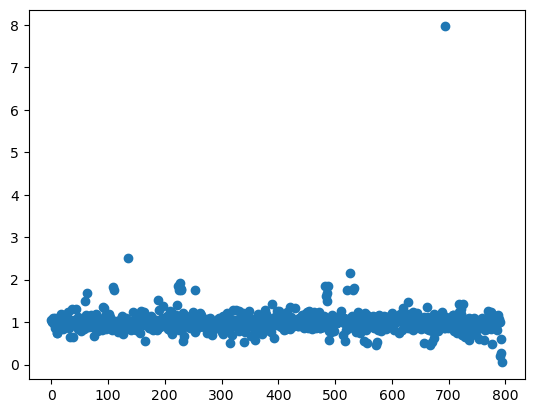

In [197]:
plt.plot(wgr, 'o');

In [ ]:
%%time
const_dict = constraints_ind | constraints_viv

Y_ext = Y_fix.copy()

mun_list = [m for m in Y.MUN.unique() if m != 'IMPUTED']
for mun in mun_list:
    print(mun)
    fix_confs_mun(mun, Y_ext, personas, viviendas, U, C, L, const_dict)

## Collective

In [11]:
df_mun_loc = locate_collective(df_mun, df_loc)

In [12]:
for mun, n_p, n_v, df in df_mun_loc:
    print(mun, n_p, n_v, df.index.values)

7 8.0 1.0 [ 29 216 219 221 269 344]
9 1873.0 1.0 [620]
31 10.0 1.0 [160 298]
49 4.0 1.0 [ 22  57  58  67  77 127 128 138 139 149 180 196 197 206 209 233 236 254
 272 278 289 295 296]


## Different type of solutions

In [16]:
import scipy.linalg as spl
from scipy.optimize import nnls

In [11]:
mun = 'Cerralvo'
X2 = XWC_dict[mun]['X']
W2 = XWC_dict[mun]['W']
C2 = XWC_dict[mun]['C']

check_solvable(W2, C2)

True

In [106]:
W.shape, W2.shape

((97, 2882), (183, 2882))

In [90]:
# Non negative least squares solution

X_sol_nn, err = nnls(W, C)
np.linalg.norm(W.values @ X_sol_nn - C.values, ord=1), np.linalg.norm(X_sol_nn)

(6.67119692820961e-11, 1280.5252064123974)

In [91]:
X_sol_nn2, err = nnls(W2, C2)
np.linalg.norm(W2.values @ X_sol_nn2 - C2.values, ord=1), np.linalg.norm(X_sol_nn2)

(9.615463980594541e-11, 1091.7601945594413)

In [100]:
# Least squares solution

W_inv = spl.pinv(W)
X_sol = W_inv @ C.values
np.linalg.norm(W.values @ X_sol - C.values, ord=1), np.linalg.norm(X_sol)

(2.957613265408554e-09, 174.80568107488986)

In [104]:
# Least squares solution

W_inv = spl.pinv(W2)
X_sol2 = W_inv @ C2.values
np.linalg.norm(W2.values @ X_sol2 - C2.values, ord=1), np.linalg.norm(X_sol2)

(1.2072849386868256e-09, 174.805681074888)

In [105]:
np.linalg.norm(X_sol2 - X_sol)

5.845229258204539e-10

In [518]:
from ipf import ipf_classic_numba

In [107]:
%%time
# The IPF solution
x = X.FACTOR.values.astype(float)
x_ipf, err = ipf_classic_numba(x, W.values.astype(float), C.values, tol=1e-1, max_iters=1e4)
err, np.linalg.norm(x_ipf)

CPU times: user 7.97 s, sys: 791 ms, total: 8.76 s
Wall time: 6.36 s


(44.4800477607044, 205.72287053844428)

In [115]:
%%time
# The IPF solution
x = X2.FACTOR.values.astype(float)
x_ipf2, err = ipf_classic_numba(x, W2.values.astype(float), C2.values, tol=1e-3, max_iters=1e4)
err, np.linalg.norm(x_ipf2)

CPU times: user 1.21 s, sys: 200 ms, total: 1.41 s
Wall time: 1.15 s


(0.0009983262271617832, 206.0888458338842)

In [681]:
# The max ent solution

### Seed from group counts

In [ ]:
# Seed for whole met area

In [ ]:
# Seed per municipality

In [ ]:
# Comparing seeds from municipality and whole area

### Seed using bayesian networks

### Comparing both seeds

# Reconstrucción de microdatos para el censo 2020, nivel AGEB

El objetivo es obtener una base de microdatos para cada AGEB del censo 2020 consistente con los tabulados oficiales.
Para tal efecto, vamos a probar diferentes metodologías, comenzando con una estrategia de reconstrucción utilizando métodos de programación lineal.

Para tener una idea clara de la implementación, tomemos una AGEB específica de la zona metropolitana de Monterrey.

A nivel municipio o demarcación territorial, localidad y AGEB, cualquier indicador con menos de tres unidades aparece con asterisco
a excepción de las variables Población total (POBTOT), Total de viviendas (VIVTOT) y Total de viviendas habitadas (TVIVHAB).

Para comenzar vamos a restringir nuestro objetivos a dos variables: edad y sexo. Usemos una AGEB sin datos faltantes, más adelante ajustaremos la implementación para contemplar los datos redactados (*).

Porbaremos con dos AGEBs,  una será la de menor población con datos columnos para las columnas que se refieren a población y sexo, la segunda la de mayor población.

Las columnas de población en la tabla de microdatos serán discretizadas en el menor número intervalos compatibles con las categorías del censo que puedan aprovechar las restricciones.
La ventaja de no usar una única columna de edad con valor entero es la disminución de tamaño del espacio de soluciones.
Imputar una edad específica puede hacerse en una etapa de procesamiento posterior.
Para no contar dos veces soluciones que unicamente difieren en el ordenamiento de las filas, agregaremos restricciones de ordenamiento para los valores de edad.

Las categorias posibles de obtener del censo son las siguientes y las codificamos como enteros:
- 0-2: 0
- 3-4: 1
- 5: 2
- 6-7: 3
- 8-11: 4
- 12-14: 5
- 15-17: 6
- 18-24: 7
- 25-59: 8
- 60-64: 9
- 65-130: 10

Tener esta codificación en mente es importante al momento de definir las restricciones.

Al momento de crear los objetivos, usaremos un arreglo de variables en 2D, la tabla de microdatos.
Esto debe ser compatible con OR-Tools, por lo que será implementado como una lista de listas.
Es este problema restringido a edad y sexo, necesitamos dos columnas: SEXO y EDAD.

In [40]:
def series_to_dict(series):
    d = series.to_dict()
    keys = d.keys()
    
    vals = d.values()
    vals = [int(v) 
            if isinstance(v, float) and not np.isnan(v)
            else v for v in d.values() ]
    
    d = {k: v for k,v in zip(keys, vals)}
    
    return d

## Codificando directamente la tabla de contingencia

In [43]:
from ortools.sat.python import cp_model
from itertools import product

In [44]:
class VarArraySolutionPrinter(cp_model.CpSolverSolutionCallback):
    """Print intermediate solutions."""

    def __init__(self, variables):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.__variables = variables
        self.__solution_count = 0

    def on_solution_callback(self):
        self.__solution_count += 1
        #for v in self.__variables:
        #    print('%s=%i' % (v, self.Value(v)), end=' ')
        #print()

    def solution_count(self):
        return self.__solution_count

In [171]:
def create_variables(model, dimensions, N):
    x = {}
    for var_id in product(*dimensions.values()):
        x[var_id] = model.NewIntVar(0, N, f'{var_id}')

    return x

In [173]:
def add_constraint(model, ageb, dimensions, variables, c_name, c_dict, verbose=False):
    assert c_name in ageb.keys()
    
    for k, v in c_dict.items():
        assert k in dimensions.keys()
        for vv in v:
            assert vv in dimensions[k]
    
    # Replace classes with classes involved in the constraint only
    c_dims = dimensions.copy()
    for d in c_dims.keys():
        if d in c_dict.keys():
            c_dims[d] = c_dict[d]
    
    # Find all variables involved in the constraints
    c_vars = []
    for var_id in product(*c_dims.values()):
        c_vars.append(variables[var_id])
    
    if verbose:
        print(' + '.join([v.Name() for v in c_vars]) + f' = {c_name}')
    
    model.Add(sum(c_vars) == ageb[c_name])

In [174]:
model = cp_model.CpModel()

variables = create_variables(model, dimensions, ageb['POBTOT'])

for c_name, c_dict in constraints.items():
    add_constraint(model, ageb, dimensions, variables, c_name, c_dict, verbose=False)
    
solver = cp_model.CpSolver()
solution_printer = VarArraySolutionPrinter(list(x.values()))
solver.parameters.enumerate_all_solutions = True

status = solver.Solve(model, solution_printer)
print(f'Found {solution_printer.solution_count()} solutions. Status: {status}')

Found 613872 solutions. Status: 4
